# Respiratory Sound Classification V2

This time, we will try splitting the spectrograms into a sequence of short patches (time slices) and feed them to an LSTM after extracting features with a CNN. This way, we can (theoretically) capture temporal patterns better in the audio data.

In [37]:
import os, glob, random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm

DATA_DIR = "C://Users/Malik/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database"
SOUND_DIR = os.path.join(DATA_DIR, "audio_and_txt_files")

SAMPLE_RATE = 22050
N_MELS = 128
SPEC_WIDTH = 128   # time frames target for spectrogram images (columns)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [38]:
# Parse annotations & build sample list

def parse_annotation_file(ann_path):
    df = pd.read_csv(ann_path, header=None, sep=r'\s+', engine='python',
                     names=['start', 'end', 'crackle', 'wheeze'])
    df['duration'] = df['end'] - df['start']
    return df

def list_pairs(audio_dir=SOUND_DIR, ann_dir=SOUND_DIR):
    audio_files = glob.glob(os.path.join(audio_dir, "*.wav"))
    pairs = []
    for a in audio_files:
        base = Path(a).stem
        ann = os.path.join(ann_dir, base + ".txt")
        if os.path.exists(ann):
            pairs.append((a, ann))
    return pairs

def build_cycle_samples(pairs):
    """Return list of tuples: (audio_path, start, end, binary_label)"""
    samples = []
    for audio_path, ann_path in pairs:
        df = parse_annotation_file(ann_path)
        for _, r in df.iterrows():
            start, end = float(r['start']), float(r['end'])
            label = 1 if (int(r['crackle']) == 1 or int(r['wheeze']) == 1) else 0
            samples.append((audio_path, start, end, label))
    random.shuffle(samples)
    return samples

# small util: pad/crop mel to SPEC_WIDTH
def extract_mel_segment(audio_path, start, end, sr=SAMPLE_RATE, n_mels=N_MELS, fmax=8000, hop_length=512, target_width=SPEC_WIDTH):
    y, sr = librosa.load(audio_path, sr=sr)
    s1 = int(start * sr)
    s2 = int(end * sr)
    seg = y[s1:s2]
    if len(seg) < 0.3 * sr:  # minimal padding
        seg = np.pad(seg, (0, int(0.3*sr) - len(seg)), mode='constant')
    mel = librosa.feature.melspectrogram(y=seg, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # pad or crop time axis to target_width
    _, T = mel_db.shape
    if T < target_width:
        mel_db = np.pad(mel_db, ((0,0),(0, target_width - T)), mode='constant', constant_values=(mel_db.min(),))
    elif T > target_width:
        start_col = (T - target_width)//2
        mel_db = mel_db[:, start_col:start_col+target_width]
    return mel_db  # shape (n_mels, target_width)


MEL to sequence of patches to LSTM

In [39]:
# We'll treat spectrogram as (n_mels, T, channels) and split T into S segments, encode each with shared CNN, then LSTM

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

SEGMENTS = 8  # number of time segments to split the SPEC_WIDTH into
segment_width = SPEC_WIDTH // SEGMENTS

def mel_to_sequence(mel):
    # mel: (n_mels, SPEC_WIDTH)
    # produce SEGMENTS slices of shape (n_mels, segment_width, 1) each
    seq = []
    for i in range(SEGMENTS):
        start = i * segment_width
        seg = mel[:, start:start+segment_width]
        if seg.shape[1] < segment_width:
            seg = np.pad(seg, ((0,0),(0, segment_width - seg.shape[1])), mode='constant', constant_values=(mel.min(),))
        # stack channels
        delta = librosa.feature.delta(seg)
        delta2 = librosa.feature.delta(seg, order=2)
        stacked = np.stack([seg, delta, delta2], axis=-1)
        stacked = (stacked - stacked.mean()) / (stacked.std() + 1e-9)
        seq.append(stacked.astype(np.float32))
    return np.array(seq)  # shape (SEGMENTS, n_mels, segment_width, 3)

# Prepare numpy arrays (this returns X shape (N, SEGMENTS, n_mels, seg_w, 3))
def gen_sequence_arrays(samples):
    X_seq = []
    y = []
    for audio_path, start, end, label in samples:
        mel = extract_mel_segment(audio_path, start, end)
        seq = mel_to_sequence(mel)  # (SEGMENTS, n_mels, seg_w, 3)
        X_seq.append(seq)
        y.append(label)
    return np.array(X_seq), np.array(y).astype(np.float32)

# build train/val arrays
pairs = list_pairs()
samples = build_cycle_samples(pairs)
train_s, val_s = train_test_split(samples, test_size=0.2, random_state=SEED, stratify=[s[3] for s in samples])

X_train_seq, y_train = gen_sequence_arrays(train_s)
X_val_seq, y_val = gen_sequence_arrays(val_s)

# Model architecture: shared small CNN encoder -> TimeDistributed -> BiLSTM -> Dense
n_mels = N_MELS
seg_w = segment_width
channels = 3

def build_cnn_encoder():
    inp = layers.Input(shape=(n_mels, seg_w, channels))
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    model = models.Model(inputs=inp, outputs=x)
    return model

encoder = build_cnn_encoder()
# sequence input: (SEGMENTS, n_mels, seg_w, 3)
seq_inp = layers.Input(shape=(SEGMENTS, n_mels, seg_w, channels))
# apply encoder time-distributed
td = layers.TimeDistributed(encoder)(seq_inp)  # (batch, SEGMENTS, features)
# BiLSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(td)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model_seq = models.Model(inputs=seq_inp, outputs=out)

model_seq.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_seq.summary()

# Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_seq.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val),
                        epochs=30, batch_size=16, callbacks=[es])

# Evaluate
val_preds = (model_seq.predict(X_val_seq) > 0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_val, val_preds, target_names=['normal','abnormal']))

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 8, 128, 16, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 8, 32)          │         5,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 128)            │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073 (246.38 KB)

 Trainable params: 63,073 (246.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5212 - loss: 0.6913 - val_accuracy: 0.5283 - val_loss: 0.6927
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5212 - loss: 0.6913 - val_accuracy: 0.5283 - val_loss: 0.6927
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5252 - loss: 0.6924 - val_accuracy: 0.5283 - val_loss: 0.6913
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5252 - loss: 0.6924 - val_accuracy: 0.5283 - val_loss: 0.6913
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5234 - loss: 0.6917 - val_accuracy: 0.5283 - val_loss: 0.6914
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5234 - loss: 0.6917 - val_accuracy: 0.5283 - val_loss: 0.6914
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5263 - loss: 0.6916 - val_accuracy: 0.5254 - val_loss: 0.6911
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5263 - loss: 0.6916 - val_accu

In [42]:
encoder = build_cnn_encoder()
# sequence input: (SEGMENTS, n_mels, seg_w, 3)
seq_inp = layers.Input(shape=(SEGMENTS, n_mels, seg_w, channels))
# apply encoder time-distributed
td = layers.TimeDistributed(encoder)(seq_inp)  # (batch, SEGMENTS, features)
# BiLSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(td)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model_seq = models.Model(inputs=seq_inp, outputs=out)

model_seq.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_seq.summary()

# Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_seq.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val),
                        epochs=30, batch_size=16, callbacks=[es])

# Evaluate
val_preds = (model_seq.predict(X_val_seq) > 0.5).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_val, val_preds, target_names=['normal','abnormal']))

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 8, 128, 16, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 8, 32)          │         5,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 128)            │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073 (246.38 KB)

 Trainable params: 63,073 (246.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5246 - loss: 0.6926 - val_accuracy: 0.5283 - val_loss: 0.6916
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5246 - loss: 0.6926 - val_accuracy: 0.5283 - val_loss: 0.6916
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5283 - val_loss: 0.6916
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5283 - val_loss: 0.6916
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5283 - val_loss: 0.6918
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5274 - loss: 0.6918 - val_accuracy: 0.5283 - val_loss: 0.6918
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5283 - loss: 0.6918 - val_accuracy: 0.5283 - val_loss: 0.6910
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5283 - loss: 0.6918 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

      normal       0.64      0.56      0.60       729
    abnormal       0.57      0.64      0.60       651

    accuracy                           0.60      1380
   macro avg       0.60      0.60      0.60      1380
weighted avg       0.60      0.60      0.60      1380

              precision    recall  f1-score   support

      normal       0.64      0.56      0.60       729
    abnormal       0.57      0.64      0.60       651

    accuracy                           0.60      1380
   macro avg       0.60      0.60      0.60      1380
weighted avg       0.60      0.60      0.60      1380



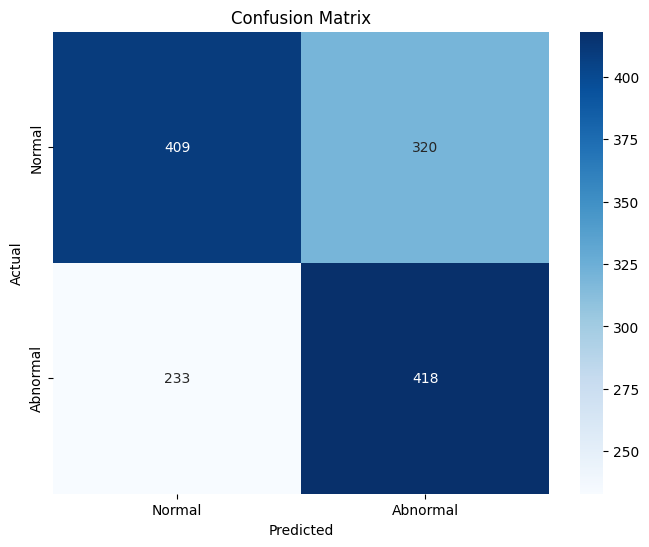

In [43]:
# Generate predictions for the validation set
val_preds = (model_seq.predict(X_val_seq) > 0.5).astype(int)

print(classification_report(y_val, val_preds, target_names=['normal', 'abnormal']))

# Compute the confusion matrix
cm = confusion_matrix(y_val, val_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

61% accuracy is a step up from previous ~55% accuracy.